In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

from numba import jit

import sys
sys.path.append('..')
from lib import *
from lib.maxent import *
plt.style.use('../peptidome.mplstyle')

In [5]:
models = ['train', 'independent', 'ncov', 'nskew', 'nskewfcov']

In [17]:
model = 'nskewfcov'
matrix = load_matrix('data/Humannozf_{model}_k9_matrix.csv.gz'.format(model=model))
matrix.shape

(5421776, 9)

In [7]:
bt = BallTree(matrix[:500000, :], metric='hamming')

In [18]:
dists = (bt.query(matrix[500000:501000, :], return_distance=True)[0]*9).flatten()

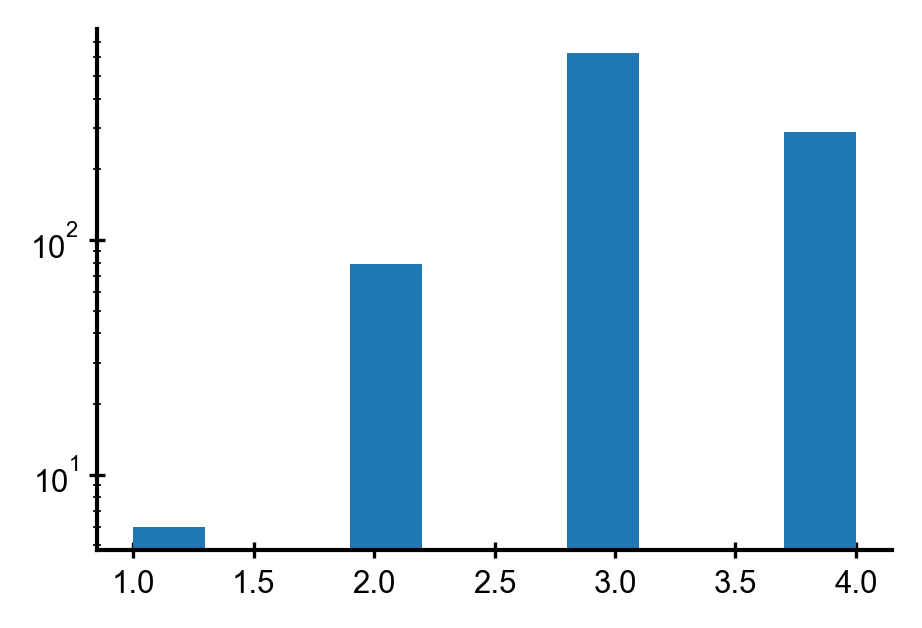

In [22]:
plt.hist(dists)
plt.yscale('log')

In [21]:
# use spotify annoy? https://github.com/spotify/annoy